In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Analysis

In [2]:
df_2023_2024 = pd.read_excel('KhalsaGarments2023to2024.xlsx')
df_2024_2025 = pd.read_excel('KhalsaGarments2024to2025.xlsx')
for df in [df_2023_2024, df_2024_2025]:
    for col in ['Production Quantity', 'Sales Quantity', 'Inventory Quantity', 'Revenue']:
        df[col].replace('-', 0, inplace=True)
        df[col] = df[col].astype(float)
    df['Date'] = pd.to_datetime(df['Date'])
merged_df = pd.concat([df_2023_2024, df_2024_2025])
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 797 entries, 0 to 392
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Date                 797 non-null    datetime64[ns]
 1   Product Name         797 non-null    object        
 2   Segment              797 non-null    object        
 3   Color                797 non-null    object        
 4   Pattern              797 non-null    object        
 5   Production Quantity  797 non-null    float64       
 6   Sales Quantity       797 non-null    float64       
 7   Inventory Quantity   797 non-null    float64       
 8   Price                797 non-null    int64         
 9   Revenue              797 non-null    float64       
dtypes: datetime64[ns](1), float64(4), int64(1), object(4)
memory usage: 68.5+ KB


In [3]:
print("2023 to 2024")
df_2023_2024.describe().round(2) # Output:

2023 to 2024


,Production Quantity,Sales Quantity,Inventory Quantity,Price,Revenue
count,404.00,404.00,404.00,404.00,404.00
mean,33.27,30.56,55.43,351.24,10070.42
std,18.95,69.26,54.57,136.64,24219.27
min,1.00,0.00,0.00,150.00,0.00
25%,17.75,0.00,5.00,300.00,0.00
50%,34.50,0.00,44.50,300.00,0.00
75%,49.25,0.00,88.25,450.00,0.00
max,68.00,324.00,263.00,650.00,154050.00


In [4]:
print("2024 to 2025")
df_2024_2025.describe().round(2) # Output:

2024 to 2025


,Production Quantity,Sales Quantity,Inventory Quantity,Price,Revenue
count,393.00,393.00,393.00,393.00,393.00
mean,33.92,31.99,54.59,364.73,11165.24
std,19.28,70.89,55.97,143.93,26290.10
min,1.00,0.00,0.00,150.00,0.00
25%,17.00,0.00,5.00,310.00,0.00
50%,36.00,0.00,40.00,310.00,0.00
75%,50.00,0.00,84.00,470.00,0.00
max,68.00,334.00,268.00,680.00,164560.00


In [5]:
unique_colors = len(set(color.strip() for colors in merged_df["Color"] for color in colors.split(",")))
unique_patterns = len(set(color.strip() for patterns in merged_df["Pattern"] for color in patterns.split(",")))
unique_product_names = len(set(merged_df["Product Name"]))

print(f"Unique colors: {unique_colors}")
print(f"Unique patterns: {unique_patterns}")
print(f"Unique product names: {unique_product_names}")


Unique colors: 17
Unique patterns: 37
Unique product names: 11


In [6]:
print(list(set(merged_df["Product Name"])))

['Joggers', 'Shirt (Kids)', 'T Shirt (Kids)', 'Windcheater', 'Shirt', 'Hoodie', 'T Shirt', 'Track Suit', 'Shorts', 'Sweat Shirt', 'Shorts (Kids)']


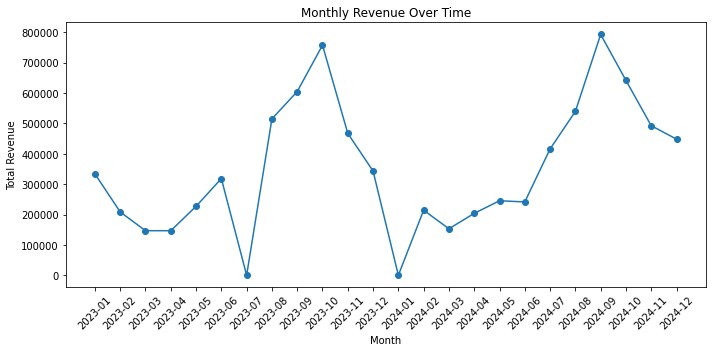

In [7]:
merged_df['YearMonth'] = merged_df['Date'].dt.to_period('M').astype(str)

# Group by YearMonth to sum Revenue and (if available) Sales Quantity
monthly_summary = merged_df.groupby('YearMonth').agg({'Revenue': 'sum', 'Sales Quantity': 'sum'}).reset_index()

plt.figure(figsize=(10, 5))
plt.plot(monthly_summary['YearMonth'], monthly_summary['Revenue'], marker='o')
plt.xticks(rotation=45)
plt.xlabel('Month')
plt.ylabel('Total Revenue')
plt.title('Monthly Revenue Over Time')
plt.tight_layout()
plt.show()

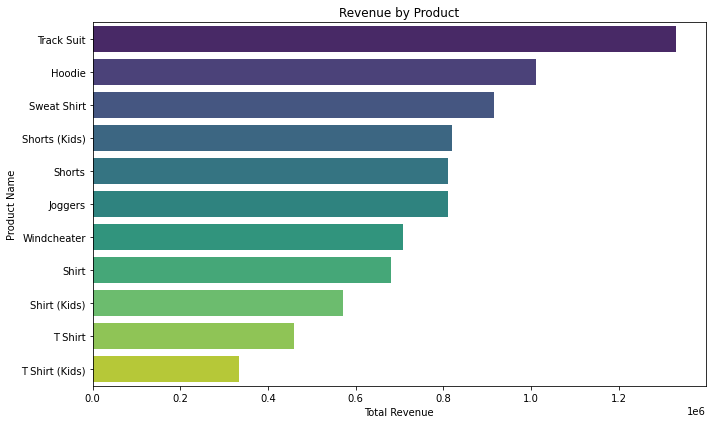

In [8]:
product_revenue = merged_df.groupby('Product Name')['Revenue'].sum().reset_index().sort_values(by='Revenue', ascending=False)

# Bar chart: Revenue by Product
plt.figure(figsize=(10, 6))
sns.barplot(data=product_revenue, x='Revenue', y='Product Name', palette='viridis')
plt.xlabel('Total Revenue')
plt.ylabel('Product Name')
plt.title('Revenue by Product')
plt.tight_layout()
plt.show()

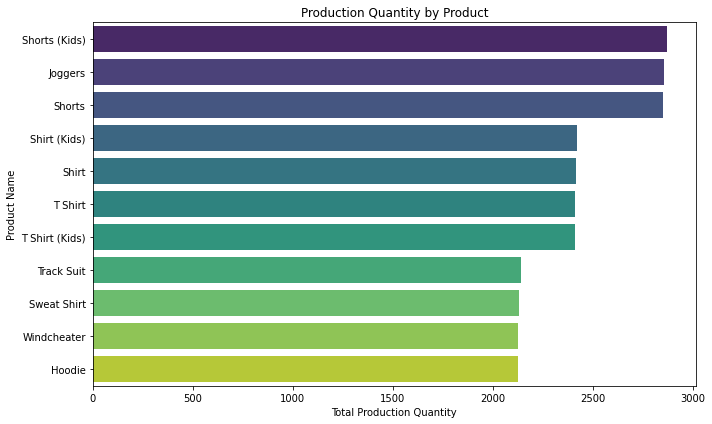

In [9]:
product_revenue = merged_df.groupby('Product Name')['Production Quantity'].sum().reset_index().sort_values(by='Production Quantity', ascending=False)

# Bar chart: Production Quantity by Product
plt.figure(figsize=(10, 6))
sns.barplot(data=product_revenue, x='Production Quantity', y='Product Name', palette='viridis')
plt.xlabel('Total Production Quantity')
plt.ylabel('Product Name')
plt.title('Production Quantity by Product')
plt.tight_layout()
plt.show()

In [10]:
merged_df.columns

Index(['Date', 'Product Name', 'Segment', 'Color', 'Pattern',
       'Production Quantity', 'Sales Quantity', 'Inventory Quantity', 'Price',
       'Revenue', 'YearMonth'],
      dtype='object')

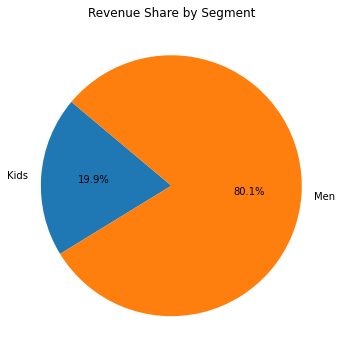

Revenue by Segment:
  Segment    Revenue
0    Kids   871430.0
1     Men  3516510.0


In [11]:
segment_revenue = df.groupby('Segment')['Revenue'].sum().reset_index()

# Pie chart: Revenue by Segment
plt.figure(figsize=(6, 6))
plt.pie(segment_revenue['Revenue'], labels=segment_revenue['Segment'], autopct='%1.1f%%', startangle=140)
plt.title('Revenue Share by Segment')
plt.show()

print("Revenue by Segment:")
print(segment_revenue)

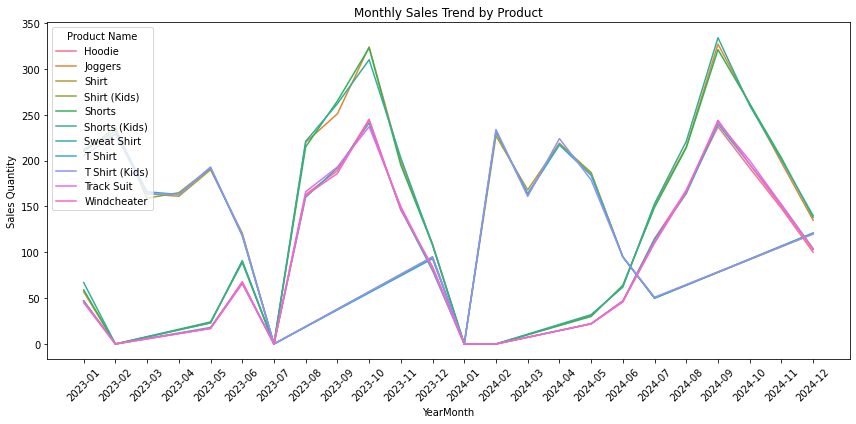

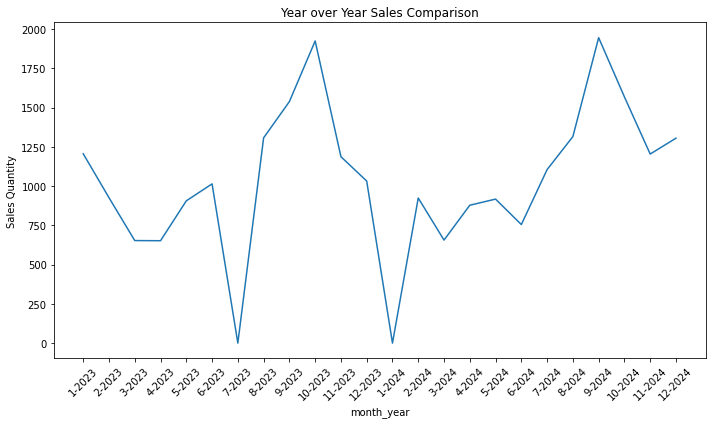

In [12]:
def plot_seasonality(merged_df):
    # Monthly sales trend - aggregating by YearMonth
    monthly_sales = merged_df.groupby(['YearMonth', 'Product Name'])['Sales Quantity'].sum().reset_index()
    
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=monthly_sales, x='YearMonth', y='Sales Quantity', hue='Product Name')
    plt.title('Monthly Sales Trend by Product')
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    # YoY comparison: grouping by year and month from the Date column
    monthly_total = merged_df.groupby([
        merged_df['Date'].dt.year.rename('year'),
        merged_df['Date'].dt.month.rename('month')
    ])['Sales Quantity'].sum().reset_index()
    
    monthly_total['month_year'] = monthly_total.apply(
        lambda x: f"{int(x['month'])}-{int(x['year'])}", axis=1
    )
    
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=monthly_total, x='month_year', y='Sales Quantity')
    plt.title('Year over Year Sales Comparison')
    plt.xticks(rotation=45)
    plt.tight_layout()

# Example usage (ensure merged_df is properly defined and 'Date' is a datetime type)
plot_seasonality(merged_df)


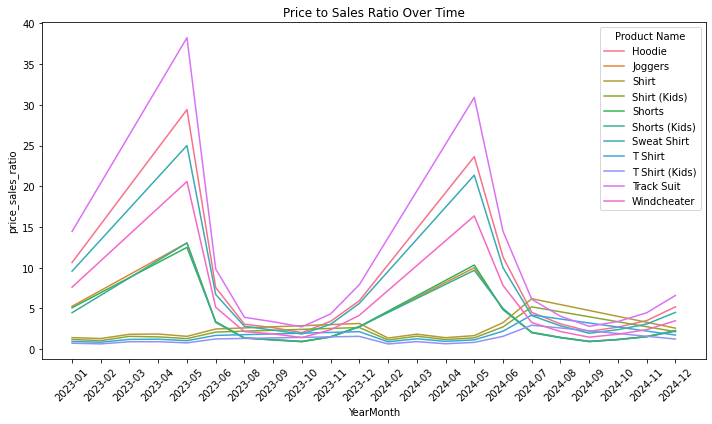

In [13]:
def plot_price_elasticity(merged_df):
    # Remove rows where Sales Quantity is 0 or null
    valid_sales = merged_df[merged_df['Sales Quantity'] > 0].copy()
    # Price-to-sales ratio trend
    valid_sales['price_sales_ratio'] = valid_sales['Price'] / valid_sales['Sales Quantity']
    monthly_ratio = valid_sales.groupby(['YearMonth', 'Product Name'])['price_sales_ratio'].mean().reset_index()
    
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=monthly_ratio, x='YearMonth', y='price_sales_ratio', hue='Product Name')
    plt.title('Price to Sales Ratio Over Time')
    plt.xticks(rotation=45)
    plt.tight_layout()
    

plot_price_elasticity(merged_df)
